In [1]:
import numpy as np
import pandas as pd
from scipy import spatial
# import volpriceinference a vl
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
logging.getLogger().addHandler(logging.FileHandler("logging.tmp.txt"))

## Load the data

In [4]:
data_in = pd.read_csv('../data/spy_daily_data_2000-2017.csv', index_col=0, parse_dates=True).dropna()
data = pd.DataFrame(data_in['log_rtn']).rename(columns={'log_rtn':'rtn'})
data['vol'] = data_in['real_vol']
data['rtn'] *= np.mean(data['vol']) / np.mean(data['rtn']**2)
data['vol'] *= 252**2
data['rtn'] *= 252

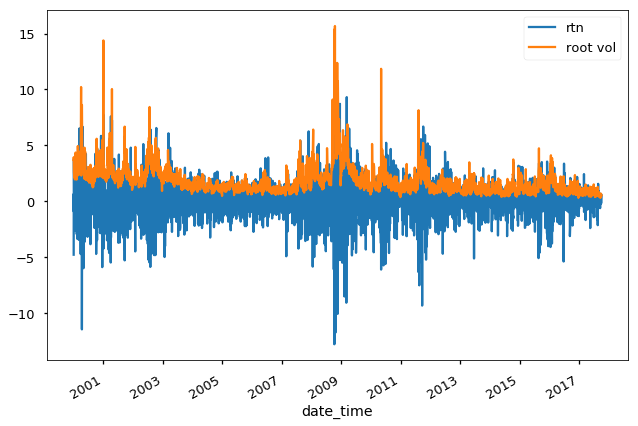

In [5]:
fig1, ax1 = mpl.pyplot.subplots()
data['rtn'].plot(ax=ax1)
data['vol'].apply(np.sqrt).plot(ax=ax1, label='root vol')
ax1.legend()

In [6]:
data.describe()

,rtn,vol
count,3498.000000,3498.000000
mean,0.016345,4.930527
std,1.769479,11.339512
min,-12.768501,0.116845
25%,-0.815902,1.080014
50%,0.054643,2.268725
75%,0.867486,4.852287
max,9.316178,245.524620


In [7]:
omega, omega_cov = vl.estimate_params(data)

In [8]:
omega

{'gamma': 0.27642136911534676,
 'beta': 0.07622156617117729,
 'psi': -0.12877888496624013,
 'zeta': 0.788964436367009,
 'delta': 4.531959772455613,
 'rho': 0.4403775585929688,
 'scale': 0.44985285109353323}

In [9]:
vl.estimate_params_strong_id(data)

({'gamma': 0.27642136911534676,
  'beta': 0.07622156617117729,
  'psi': -0.12877888496624013,
  'zeta': 0.788964436367009,
  'delta': 4.531959772455613,
  'rho': 0.4403775585929688,
  'scale': 0.44985285109353323,
  'equity_price': 0.5295007710346796,
  'vol_price': -0.5851885980790834},
                   beta       delta  equity_price     gamma       psi  \
 beta          0.000057    0.000000           NaN -0.000025 -0.000052   
 delta         0.000000  489.432394           NaN  0.000000  0.000000   
 equity_price       NaN         NaN      0.002658       NaN       NaN   
 gamma        -0.000025    0.000000           NaN  0.000446 -0.000065   
 psi          -0.000052    0.000000           NaN -0.000065  0.000111   
 rho           0.000000   -0.253888           NaN  0.000000  0.000000   
 scale         0.000000  -48.664955           NaN  0.000000  0.000000   
 vol_price          NaN         NaN     -0.023843       NaN       NaN   
 zeta          0.000000    0.000000           NaN  0.0

In [10]:
qlr_stats = vl.compute_qlr_stats(omega=omega, omega_cov=omega_cov, vol_dim=100, equity_dim=100, equity_max=5,
                                vol_min=-15)

In [ ]:
qlr_draws = vl.compute_qlr_sim(omega=omega, omega_cov=omega_cov, vol_dim=100, equity_dim=100, equity_max=5,
                                vol_min=-15, innov_dim=200)

In [ ]:
accepted_vals = (qlr_stats < qlr_draws).stack().reset_index().rename(columns={0:'value'}).query(
    'value').drop('value', axis='columns')

In [ ]:
fig3, ax3 = mpl.pyplot.subplots()
sns.scatterplot(y=accepted_vals.equity, x=accepted_vals.vol, ax=ax3)
ax3.set_xlim([-15.5, .5])
ax3.set_ylim([-.5,2.5])
hull = spatial.ConvexHull(accepted_vals.values)
ax3.fill(accepted_vals.values[hull.vertices, 0], accepted_vals.values[hull.vertices, 1], 'k-', color='green', 
        alpha=.5)
ax3.legend()